In [12]:
import os
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

from palettable.colorbrewer.sequential import YlGn_9
from palettable.cmocean.sequential import Tempo_10
from palettable.colorbrewer.diverging import PuOr_7
from palettable.cartocolors.sequential import PurpOr_6

from ideotype.data_process import (read_data,
                                   fetch_norm_mean_disp,
                                   fetch_mean_disp_diff,
                                   fetch_sim_values)
from ideotype.analysis import (rank_top_phenos, 
                               identify_top_phenos,
                               identify_improved_phenos, 
                               phenostage_climate)
from ideotype.figures import (plot_rankchange,
                              plot_params_heatmap,
                              plot_cspace_rank,
                              plot_cspace_yield,
                              plot_mean_disp_change)
from ideotype.init_params import params_sample
from ideotype.utils import fold
from ideotype.data_process import parse_mature
from ideotype import DATA_PATH

In [7]:
# Read in data etc.
run_name = 'present'
df_sims, df_sites, df_wea, df_params, df_all, df_matured = read_data(
    f'/home/disk/eos8/ach315/ideotype/ideotype/data/files/filepaths_{run_name}.yml')
df_extended, df_stuck = parse_mature(df_all)
df_all.drop(df_stuck.index, inplace=True)

In [10]:
# Read in data etc.
run_name = 'present'
df_sims, df_sites, df_wea, df_params, df_all, df_matured = read_data(
    f'/home/disk/eos8/ach315/ideotype/ideotype/data/files/filepaths_{run_name}.yml')
df_extended, df_stuck = parse_mature(df_all)
df_all.drop(df_stuck.index, inplace=True)

# Queried maizsim outputs
df_sims = pd.read_csv(os.path.join(DATA_PATH, 'sims', f'sims_{run_name}_yield.csv'))
df_phys = pd.read_csv(os.path.join(DATA_PATH, 'sims', f'sims_{run_name}_phys.csv'))
df_carbon = pd.read_csv(os.path.join(DATA_PATH, 'sims', f'sims_{run_name}_carbon.csv'))
df_mass = pd.read_csv(os.path.join(DATA_PATH, 'sims', f'sims_{run_name}_mass.csv'))
df_leaves = pd.read_csv(os.path.join(DATA_PATH, 'sims', f'sims_{run_name}_leaves.csv'))
df_waterdeficit = pd.read_csv(os.path.join(DATA_PATH, 'sims', f'sims_{run_name}_waterdeficit.csv'))
df_waterdeficit_sum = pd.read_csv(os.path.join(DATA_PATH, 'sims', f'sims_{run_name}_waterdeficit_sum.csv'))
df_waterpotential = pd.read_csv(os.path.join(DATA_PATH, 'sims', f'sims_{run_name}_waterpotential.csv'))
df_phenology = pd.read_csv(os.path.join(DATA_PATH, 'sims', f'sims_{run_name}_pheno.csv'))
start_dates = [int(datetime.strptime(date, '%m/%d/%Y').strftime('%j')) for date in df_phenology.date_start]
df_phenology['jday'] = start_dates
df_gseason_climate = pd.read_csv(os.path.join(DATA_PATH, 'sims', f'sims_{run_name}_gseason_climate.csv'))

In [26]:
# Read in data for future sims
run_name = 'f2100'
df_sims, df_sites, df_wea, df_params, df_all_f2100, df_matured = read_data(
    f'/home/disk/eos8/ach315/ideotype/ideotype/data/files/filepaths_{run_name}.yml')
df_extended, df_stuck = parse_mature(df_all_f2100)
df_all_f2100.drop(df_stuck.index, inplace=True)

In [13]:
# fetch emergent properties
phenos_ranked = rank_top_phenos('present', 100, 1, 1)
df_pheno_gf = df_phenology[df_phenology.pheno == '"grainFill"']

# grain-filling length
gf_lengths = []
for pheno in phenos_ranked:
    df_sub = df_pheno_gf.query(f'cvar=={pheno}')
    gf_length = df_sub.mean()['pheno_days']
    gf_lengths.append(gf_length)
    
# grain-filling length
gf_startdates = []
for pheno in phenos_ranked:
    df_sub = df_pheno_gf.query(f'cvar=={pheno}')
    gf_startdate = df_sub.mean()['jday']
    gf_startdates.append(gf_startdate)
    
# leaf areas
LA = fetch_sim_values(df_leaves, '"grainFill"', 'LA', phenos_ranked)

## Relationship between yield & climate

Text(0, 0.5, 'rank')

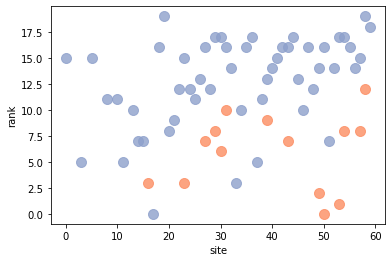

In [46]:
# thinking about ways to visualize rank change across sites
# the problem with this is that you can't really see what happened to locations that 
# were not ranked because it didn't make it into the top 20
# I don't think this is a good fig, but keep brainstorming

df_pheno, mx_present = identify_top_phenos('present',20,1,1)
df_pheno, mx_f2100 = identify_top_phenos('f2100',20,1,1)
plt.scatter(np.arange(60), 20-mx_present[58], color='#8da0cb', alpha=0.8, s=100)
plt.scatter(np.arange(60), 20-mx_f2100[58], color='#fc8d62', alpha=0.8, s=100)
plt.xlabel('site')
plt.ylabel('rank')

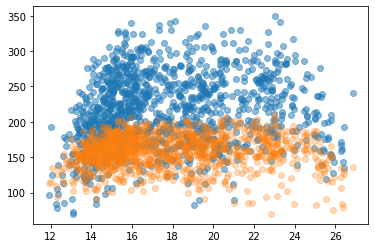

In [24]:
pheno=89
df_sub = df_all.query(f'cvar=={pheno}')
plt.scatter(df_sub.temp, df_sub.dm_ear, alpha=0.5)

pheno=44
df_sub = df_all.query(f'cvar=={pheno}')
plt.scatter(df_sub.temp, df_sub.dm_ear, alpha=0.3)

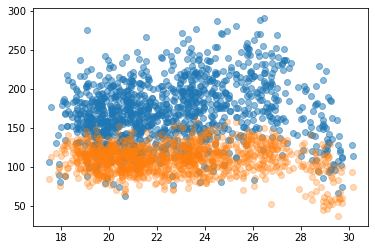

In [27]:
pheno=89
df_sub = df_all_f2100.query(f'cvar=={pheno}')
plt.scatter(df_sub.temp, df_sub.dm_ear, alpha=0.5)

pheno=44
df_sub = df_all_f2100.query(f'cvar=={pheno}')
plt.scatter(df_sub.temp, df_sub.dm_ear, alpha=0.3)

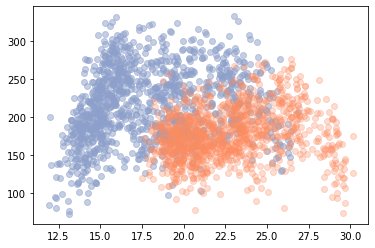

In [51]:
pheno=88
df_sub = df_all.query(f'cvar=={pheno}')
plt.scatter(df_sub.temp, df_sub.dm_ear, 
            color='#8da0cb', alpha=0.5)
df_sub = df_all_f2100.query(f'cvar=={pheno}')
plt.scatter(df_sub.temp, df_sub.dm_ear, 
            color='#fc8d62', alpha=0.3)

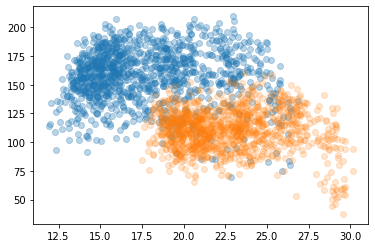

In [29]:
pheno=44
df_sub = df_all.query(f'cvar=={pheno}')
plt.scatter(df_sub.temp, df_sub.dm_ear, alpha=0.3)
df_sub = df_all_f2100.query(f'cvar=={pheno}')
plt.scatter(df_sub.temp, df_sub.dm_ear, alpha=0.2)

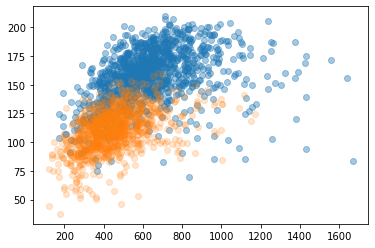

In [30]:
pheno=44
df_sub = df_all.query(f'cvar=={pheno}')
plt.scatter(df_sub.precip, df_sub.dm_ear, alpha=0.4)
df_sub = df_all_f2100.query(f'cvar=={pheno}')
plt.scatter(df_sub.precip, df_sub.dm_ear, alpha=0.2)


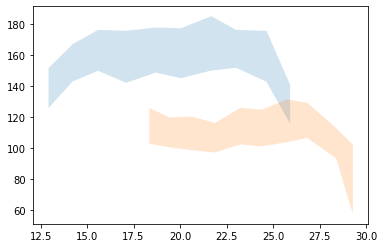

In [31]:
pheno=44
df_s = df_all.query(f'cvar=={pheno}')

n_bins=10
bins = pd.cut(df_s.temp, n_bins, labels=np.arange(n_bins).tolist())
df_sub = df_s.copy()
df_sub.loc[:,'bins'] = bins

upper_yield = [round(np.percentile(df_sub.query(f'bins=={item}').dm_ear, 75),2) for item in np.arange(n_bins)]
mid_yield = [round(np.percentile(df_sub.query(f'bins=={item}').dm_ear, 50),2) for item in np.arange(n_bins)]
lower_yield = [round(np.percentile(df_sub.query(f'bins=={item}').dm_ear, 25),2) for item in np.arange(n_bins)]
temp_means = df_sub.groupby('bins').mean().temp
plt.fill_between(temp_means, upper_yield, lower_yield, alpha=0.2)

df_s = df_all_f2100.query(f'cvar=={pheno}')

n_bins=10
bins = pd.cut(df_s.temp, n_bins, labels=np.arange(n_bins).tolist())
df_sub = df_s.copy()
df_sub.loc[:,'bins'] = bins

upper_yield = [round(np.percentile(df_sub.query(f'bins=={item}').dm_ear, 75),2) for item in np.arange(n_bins)]
mid_yield = [round(np.percentile(df_sub.query(f'bins=={item}').dm_ear, 50),2) for item in np.arange(n_bins)]
lower_yield = [round(np.percentile(df_sub.query(f'bins=={item}').dm_ear, 25),2) for item in np.arange(n_bins)]
temp_means = df_sub.groupby('bins').mean().temp
plt.fill_between(temp_means, upper_yield, lower_yield, alpha=0.2)

## Performance in cspace

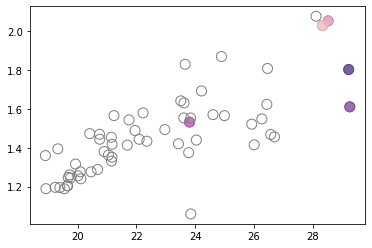

In [33]:
pheno=25
plt.scatter(df_wea.groupby('site').mean().temp, df_wea.groupby('site').mean().vpd,
            facecolor='none', edgecolor='grey',s=100)
plt.scatter(df_wea.groupby('site').mean().temp, df_wea.groupby('site').mean().vpd,
            alpha=0.8, s=100, c=mx_present[pheno], cmap=PurpOr_6.mpl_colormap.reversed(), vmax=20)

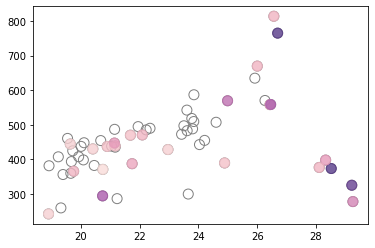

In [34]:
pheno=25
plt.scatter(df_wea.groupby('site').mean().temp, df_wea.groupby('site').mean().precip,
            facecolor='none', edgecolor='grey',s=100)
plt.scatter(df_wea.groupby('site').mean().temp, df_wea.groupby('site').mean().precip,
            alpha=0.8, s=100, c=mx_f2100[pheno], cmap=PurpOr_6.mpl_colormap.reversed(), vmax=20)

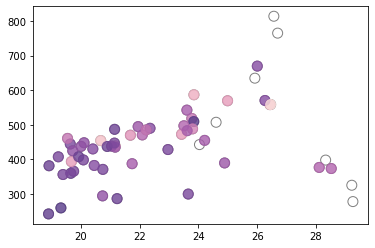

In [35]:
plt.scatter(df_wea.groupby('site').mean().temp, df_wea.groupby('site').mean().precip,
            facecolor='none', edgecolor='grey',s=100)
plt.scatter(df_wea.groupby('site').mean().temp, df_wea.groupby('site').mean().precip,
            alpha=0.8, s=100, c=mx_present[58], cmap=PurpOr_6.mpl_colormap.reversed(), vmax=20)

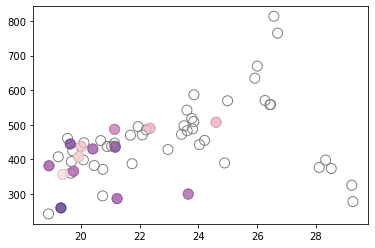

In [36]:
plt.scatter(df_wea.groupby('site').mean().temp, df_wea.groupby('site').mean().precip,
            facecolor='none', edgecolor='grey',s=100)
plt.scatter(df_wea.groupby('site').mean().temp, df_wea.groupby('site').mean().precip,
            alpha=0.8, s=100, c=mx_f2100[58], cmap=PurpOr_6.mpl_colormap.reversed(), vmax=20)

Curious that there's such a big difference in phenology within the same phenotype planted across different locations. <br/>
However, I'm not sure how much this is actually due to phenotype responses to climate differences. It could also be due to the planting date differences across sites (differences could be up to ~2 months). So management + climate resposne.

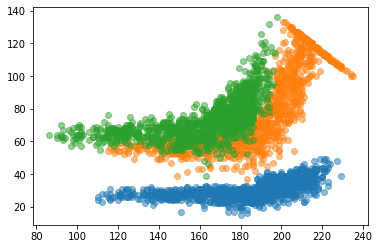

In [37]:
pheno=5
plt.scatter(test.query(f'cvar=={pheno}').jday_x, test.query(f'cvar=={pheno}').pheno_days, alpha=0.5)

pheno=89
plt.scatter(test.query(f'cvar=={pheno}').jday_x, test.query(f'cvar=={pheno}').pheno_days, alpha=0.5)

pheno=57
plt.scatter(test.query(f'cvar=={pheno}').jday_x, test.query(f'cvar=={pheno}').pheno_days, alpha=0.5)

# little relationship between reproductive start date and grain-filling length in the beginning,
# but after turning point, a later start correlates with a longer grain-fill?
# but that longer grain-fill does not lead to high yield?

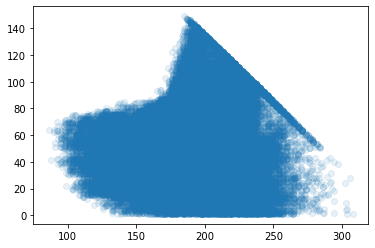

In [38]:
plt.scatter(test.jday_x, test.pheno_days, alpha=0.1)

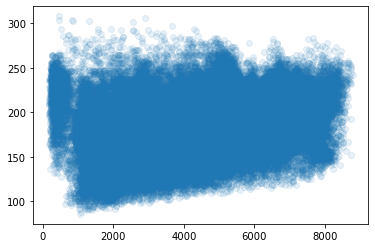

In [39]:
df_leaves_matured = df_leaves[df_leaves.pheno=='"grainFill"']
test = df_leaves_matured.merge(df_pheno_gf, on=['cvar','site','year'])
plt.scatter(test.LA, test.jday, alpha=0.1)

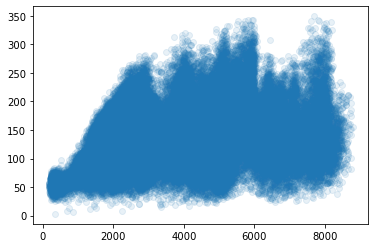

In [40]:
#df_all.site = df_all.site.astype(int)
df_leaves_matured = df_leaves[df_leaves.pheno=='"grainFill"']
test = df_leaves_matured.merge(df_all, on=['cvar','site','year'])
#plt.scatter(test.query('cvar==4').LA_x, test.query('cvar==4').dm_ear, alpha=0.5)
plt.scatter(test.LA_x, test.dm_ear, alpha=0.1)

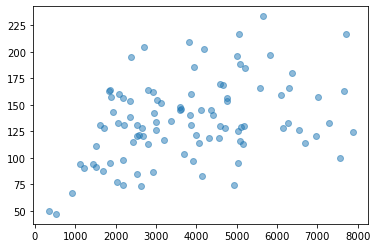

In [41]:
dm_ears = df_all.groupby('cvar').mean().dm_ear.reindex(phenos_ranked)
plt.scatter(LA, dm_ears, alpha=0.5)

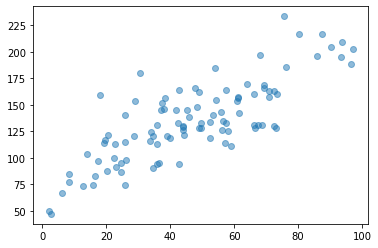

In [42]:
plt.scatter(gf_lengths, dm_ears, alpha=0.5)

## Performance in map

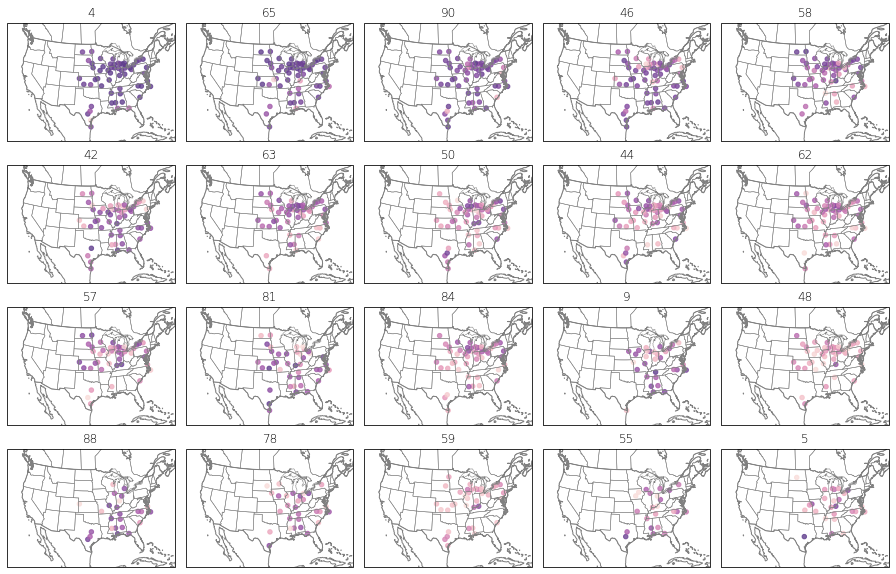

In [34]:
# Identify top phenos
df_pheno, mx = identify_top_phenos('present',20,1,1)
top_phenos = rank_top_phenos('present',20,1,1)

# Visualization
fig = plt.figure(figsize=(16,10))

for item, pheno in enumerate(top_phenos[:20]):
    ax = fig.add_subplot(4,5,item+1, projection=ccrs.AlbersEqualArea(
        central_latitude=39.5, central_longitude=-98.35))
    ax.set_extent([-123, -72, 19, 53])
    mp = ax.scatter(df_sites.lon, df_sites.lat, transform=ccrs.PlateCarree(),
                    c = mx[pheno], cmap=PurpOr_6.mpl_colormap.reversed(),
                    vmin=0, vmax=20, alpha=0.8, s=20)
    ax.add_feature(cfeature.BORDERS, edgecolor='grey')
    ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
    ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
    ax.set_title(pheno, fontweight='light')

fig.subplots_adjust(wspace=0)
    
#plt.savefig('/home/disk/eos8/ach315/upscale/figs/maps_top_pheno_ranking.png', format='png', dpi=800)

In [39]:
phenos_improved, phenos_targeted, phenos_new = identify_improved_phenos(20, 1, 1, 'f2100', 20)

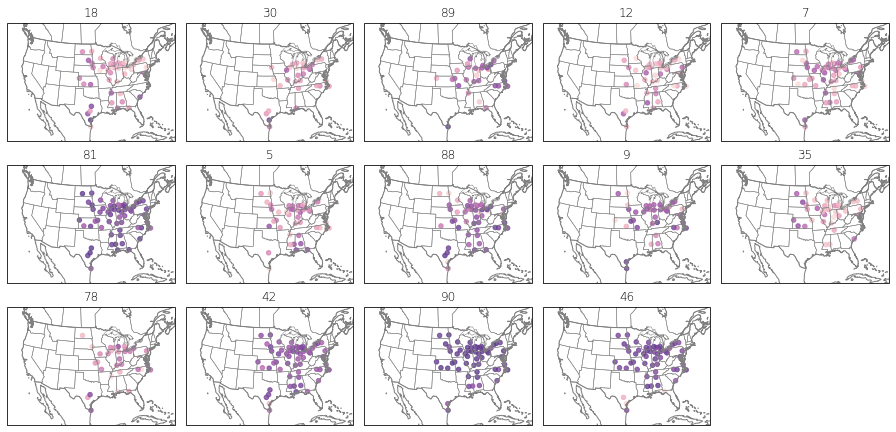

In [38]:
# Identify improved phenos under future climate
phenos_improved, phenos_targeted, phenos_new = identify_improved_phenos(20, 1, 1, 'f2100', 20)

# Identify pheno rankings under future climate sims
df_pheno, mx = identify_top_phenos('f2100', 20, 1, 1)

# Visualization
fig = plt.figure(figsize=(16,10))

for item, pheno in enumerate(phenos_targeted):
    ax = fig.add_subplot(4,5,item+1, projection=ccrs.AlbersEqualArea(
        central_latitude=39.5, central_longitude=-98.35))
    ax.set_extent([-123, -72, 19, 53])
    mp = ax.scatter(df_sites.lon, df_sites.lat, transform=ccrs.PlateCarree(),
                    c = mx[pheno], cmap=PurpOr_6.mpl_colormap.reversed(),
                    vmin=0, vmax=20, alpha=0.8, s=20)
    ax.add_feature(cfeature.BORDERS, edgecolor='grey')
    ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
    ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
    ax.set_title(pheno, fontweight='light')

fig.subplots_adjust(wspace=0)